# Human in the Loop

Langgraph supports different ways of interrumpting the control flow of a graph and allow for human intervention. The interruption of the states 

---

In [7]:
from dotenv import load_dotenv
import pandas as pd
from pathlib import Path
import json
from dotenv import load_dotenv
import os 
import pprint
from IPython.display import Image, display
from typing import TypedDict, Annotated, Literal, Dict, Any
from rich.console import Console
from rich.markdown import Markdown

Import the necessary classes from **Langchain** and **Langgraph**

In [2]:
from langgraph.graph import StateGraph, END
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver


In [61]:
# %pip install rich

In [3]:
# Load environment variables from .env file
load_dotenv()

True

We define an LLM model to use in a zero-shot mode to answer user questions

In [4]:
llm_model = "openai:"+os.getenv("OPENAI_MODEL")
print(llm_model)
llm = init_chat_model(llm_model, temperature=0)

openai:gpt-4o-mini


In [5]:
# Define the state schema
class HumanInTheLoopState(TypedDict):
    question: str  # User's original question
    ai_draft: str  # AI's initial response draft
    human_feedback: str  # Human reviewer's feedback
    final_response: str  # Final response after incorporating feedback

Definition of the nodes for the graph

In [8]:
def draft_response(state: Dict[str, Any]) -> Dict[str, Any]:
    """AI drafts an initial response to the user's question"""
    question = state["question"]
    
    # In a real application, this would use an LLM to generate a response
    # draft = f"DRAFT: Here's my initial answer to: '{question}'"
    draft = llm.invoke("Answer the following question: "+question)
    
    print(f"\n🤖 AI has drafted an initial response")
    # pprint.pprint(f"{draft.content}\n")
    return {"ai_draft": draft.content}

def get_human_feedback(state: Dict[str, Any]) -> Dict[str, Any]:
    """Collect feedback from a human reviewer"""
    # In a real application, this would be implemented with a UI
    # or messaging platform to collect human input
    print("\n👋 HUMAN REVIEW REQUIRED!\n")
    print(f"Original question: {state['question']}")
    # print(f"AI draft: {state['ai_draft']}")
    renderable_markup = Markdown(f"**AI draft:** {state['ai_draft']}")
    console.print(renderable_markup)

    # Simulating human input via console
    feedback = input("\nPlease provide feedback or type 'approve' to accept: ")
    
    print(f"\n👤 Human provided feedback: {feedback}\n")
    return {"human_feedback": feedback}

def decide_next_step(state: Dict[str, Any]) -> Literal["revise", "finalize"]:
    """Decide whether to revise the response or finalize it"""
    if state["human_feedback"].lower() == "approve":
        return "finalize"
    else:
        return "revise"

def revise_response(state: Dict[str, Any]) -> Dict[str, Any]:
    """Revise the response based on human feedback"""
    # In a real application, this would use an LLM to incorporate feedback
    old_draft = "For the following question: "+ state['question']+ ", you previously provided this answer: "+ state['ai_draft']
    revised_response = llm.invoke(old_draft + ". The user provided feedback: "+ state['human_feedback']+ ". Please revisit it and provide a new answer.")
    # revised_response = f"REVISED: I've updated my answer based on feedback: '{state['human_feedback']}'"
    
    print(f"\n🤖 AI has revised the response.")
    # pprint.pprint(f"{revised_response.content}\n")
    return {"ai_draft": revised_response.content}

def finalize_response(state: Dict[str, Any]) -> Dict[str, Any]:
    """Finalize the response and return to the user"""
    
    print(f"\n✅ Final response ready:")
    renderable_markup = Markdown(f"{state['ai_draft']}\n")
    console.print(renderable_markup)

    return {"final_response": state['ai_draft']}

Assembling the graph

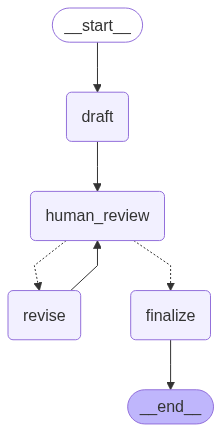

In [9]:
# Initialize the graph
graph = StateGraph(HumanInTheLoopState)

# Add nodes
graph.add_node("draft", draft_response)
graph.add_node("human_review", get_human_feedback)  # Renamed from "human_feedback"
graph.add_node("revise", revise_response)
graph.add_node("finalize", finalize_response)

# Define the flow
graph.add_edge("draft", "human_review")
graph.add_conditional_edges(
    "human_review",
    decide_next_step,
    {
        "revise": "revise",
        "finalize": "finalize"
    }
)
graph.add_edge("revise", "human_review")
graph.add_edge("finalize", END)

# Set the entry point
graph.set_entry_point("draft")

checkpointer = MemorySaver()
workflow = graph.compile(checkpointer=checkpointer)

display(Image(workflow.get_graph().draw_mermaid_png()))

In [10]:
from rich.console import Console
from rich.markdown import Markdown

# This console is only for rendering Markup content nicely
console = Console()

Testing a simple "approve" interruption

In [11]:
# Initial state with a user question
query = "What's the best way to implement HITL systems?"

initial_state = {
    "question": query,
    "ai_draft": "",
    "human_feedback": "",
    "final_response": "",
    "thread_id": 1
}

# Run the workflow
config = {"configurable": {"thread_id": 1}}
for output in workflow.stream(initial_state, config):
    # In a production application, you would handle these events appropriately
    pass
    
# Final state contains the complete conversation
print("\n=== WORKFLOW COMPLETED ===")


🤖 AI has drafted an initial response

👋 HUMAN REVIEW REQUIRED!

Original question: What's the best way to implement HITL systems?


AI draft: Implementing Human-in-the-Loop (HITL) systems effectively involves several key steps and considerations. 
Here’s a structured approach to ensure successful implementation:                                                  

  1 Define Objectives and Use Cases:                                                                               
     • Clearly outline the goals of the HITL system. Identify specific tasks where human input is necessary, such  
       as data labeling, decision-making, or quality assurance.                                                    
     • Determine the scenarios in which human intervention will enhance the system's performance.                  
  2 Select Appropriate Technology:                                                                                 
     • Choose the right tools and platforms that support HITL processes. This may include machine learning         
       frameworks, data annotation tools, and user interfaces for human operators.                                 
     • Ensure that the technology can seamlessly integrate with existing systems.                                  
  3 Design the Workflow:                                                                                           
     • Create a workflow that defines how humans will interact with the system. This includes specifying when and  
       how human input is solicited, as well as how feedback is incorporated into the system.                      
     • Consider using iterative processes where human feedback can continuously improve the model.                 
  4 User Interface and Experience:                                                                                 
     • Develop an intuitive user interface that allows human operators to easily provide input and feedback. The   
       design should minimize cognitive load and facilitate quick decision-making.                                 
     • Provide clear instructions and context for tasks to ensure that users understand their role.                
  5 Training and Onboarding:                                                                                       
     • Train human operators on the system, including how to use the interface and the importance of their         
       contributions.                                                                                              
     • Offer ongoing support and resources to help users adapt to the system and improve their performance.        
  6 Feedback Mechanisms:                                                                                           
     • Implement mechanisms for collecting feedback from human operators about the system’s performance and        
       usability.                                                                                                  
     • Use this feedback to make iterative improvements to both the technology and the workflow.                   
  7 Monitoring and Evaluation:                                                                                     
     • Continuously monitor the performance of the HITL system. Analyze the impact of human input on the overall   
       outcomes.                                                                                                   
     • Evaluate the effectiveness of the system regularly and make adjustments as needed.                          
  8 Ethical Considerations:                                                                                        
     • Address ethical concerns related to data privacy, bias, and the role of human judgment in decision-making.  
     • Ensure transparency in how human input is used and maintain accountability for decisions made by the system.
  9 Scalability and Adaptability:                                                                                  
     • Design the HITL system to be scalable, allowing 


👤 Human provided feedback: I need a Langraph example


🤖 AI has revised the response.

👋 HUMAN REVIEW REQUIRED!

Original question: What's the best way to implement HITL systems?


AI draft: Implementing Human-in-the-Loop (HITL) systems can be greatly enhanced by using a Langraph example, which 
illustrates how to structure the interaction between humans and machines in a specific context. Below is a revised 
answer that incorporates a Langraph example to clarify the implementation process:                                 

                      Implementing HITL Systems: A Structured Approach with Langraph Example                       

  1 Define Objectives and Use Cases:                                                                               
     • Example: In a medical imaging application, the objective is to improve the accuracy of disease detection in 
       X-ray images. The use case involves radiologists reviewing and annotating images flagged by an AI model.    
  2 Select Appropriate Technology:                                                                                 
     • Choose tools that support image processing and annotation. For instance, use a machine learning framework   
       like TensorFlow for model training and a user-friendly annotation tool like Labelbox for human input.       
  3 Design the Workflow:                                                                                           
     • Langraph Example: Create a flowchart that outlines the process:                                             
        • Step 1: AI model analyzes X-ray images and flags potential anomalies.                                    
        • Step 2: Images are sent to a dashboard for radiologists to review.                                       
        • Step 3: Radiologists confirm or correct the AI's findings.                                               
        • Step 4: Feedback is sent back to the AI model for retraining.                                            
  4 User Interface and Experience:                                                                                 
     • Develop an intuitive dashboard where radiologists can easily view flagged images, provide feedback, and     
       access relevant patient information. Ensure the interface highlights key areas of concern identified by the 
       AI.                                                                                                         
  5 Training and Onboarding:                                                                                       
     • Conduct training sessions for radiologists on how to use the dashboard, interpret AI suggestions, and       
       understand the importance of their feedback in improving model accuracy.                                    
  6 Feedback Mechanisms:                                                                                           
     • Implement a feedback loop where radiologists can rate the AI's suggestions and provide comments. This       
       feedback can be collected through the dashboard and analyzed to identify areas for model improvement.       
  7 Monitoring and Evaluation:                                                                                     
     • Continuously monitor the accuracy of the AI model based on radiologist feedback. Use metrics such as        
       precision, recall, and F1 score to evaluate the model's performance over time.                              
  8 Ethical Considerations:                                                                                        
     • Address concerns about data privacy by ensuring that patient data is anonymized. Discuss the implications of
       human judgment in critical medical decisions and maintain transparency about how AI suggestions are used.   
  9 Scalability and Adaptability:                                                                                  
     • Design the system to accommodate more radiologists as the workload increases. Ensure that the model can be  
       retrained with new data and feedback to adapt t


👤 Human provided feedback: approve


✅ Final response ready:


Implementing Human-in-the-Loop (HITL) systems can be greatly enhanced by using a Langraph example, which           
illustrates how to structure the interaction between humans and machines in a specific context. Below is a revised 
answer that incorporates a Langraph example to clarify the implementation process:                                 

                      Implementing HITL Systems: A Structured Approach with Langraph Example                       

  1 Define Objectives and Use Cases:                                                                               
     • Example: In a medical imaging application, the objective is to improve the accuracy of disease detection in 
       X-ray images. The use case involves radiologists reviewing and annotating images flagged by an AI model.    
  2 Select Appropriate Technology:                                                                                 
     • Choose tools that support image processing and annotation. For instance, use a machine learning framework   
       like TensorFlow for model training and a user-friendly annotation tool like Labelbox for human input.       
  3 Design the Workflow:                                                                                           
     • Langraph Example: Create a flowchart that outlines the process:                                             
        • Step 1: AI model analyzes X-ray images and flags potential anomalies.                                    
        • Step 2: Images are sent to a dashboard for radiologists to review.                                       
        • Step 3: Radiologists confirm or correct the AI's findings.                                               
        • Step 4: Feedback is sent back to the AI model for retraining.                                            
  4 User Interface and Experience:                                                                                 
     • Develop an intuitive dashboard where radiologists can easily view flagged images, provide feedback, and     
       access relevant patient information. Ensure the interface highlights key areas of concern identified by the 
       AI.                                                                                                         
  5 Training and Onboarding:                                                                                       
     • Conduct training sessions for radiologists on how to use the dashboard, interpret AI suggestions, and       
       understand the importance of their feedback in improving model accuracy.                                    
  6 Feedback Mechanisms:                                                                                           
     • Implement a feedback loop where radiologists can rate the AI's suggestions and provide comments. This       
       feedback can be collected through the dashboard and analyzed to identify areas for model improvement.       
  7 Monitoring and Evaluation:                                                                                     
     • Continuously monitor the accuracy of the AI model based on radiologist feedback. Use metrics such as        
       precision, recall, and F1 score to evaluate the model's performance over time.                              
  8 Ethical Considerations:                                                                                        
     • Address concerns about data privacy by ensuring that patient data is anonymized. Discuss the implications of
       human judgment in critical medical decisions and maintain transparency about how AI suggestions are used.   
  9 Scalability and Adaptability:                                                                                  
     • Design the system to accommodate more radiologists as the workload increases. Ensure that the model can be  
       retrained with new data and feedback to adapt t


=== WORKFLOW COMPLETED ===


---

In general, when a graph is interrupted, its state is persisted until the graph is resumed (from the interrupted node).

In [79]:
# If the graph is interrumpted, the status per thread can be checked with:

# workflow.get_state(thread_config).tasks[0].interrupts[0].value

()